In [ ]:
_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf

import random
import os
import pickle 
import sklearn
import collections
import time

from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

import import_data as impt

from class_DeepLongitudinal import Model_Longitudinal_Attention

from utils_eval             import c_index, brier_score
from utils_log              import save_logging, load_logging
from utils_helper           import f_get_minibatch, f_get_boosted_trainset


import sklearn.metrics
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import cvxpy as cp
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import minimize

In [ ]:
import matplotlib.pyplot as plt

from matplotlib import rcParams

# Set the global font to be Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Times New Roman'
rcParams['mathtext.it'] = 'Times New Roman:italic'
rcParams['mathtext.bf'] = 'Times New Roman:bold'

## 1. Import Dataset

In [ ]:
data_mode = 'FMac'
out_path = '/JLIME_Final'

df_final = pd.read_csv(out_path + '/data/FMAC_DATA.csv')
df_target = pd.read_csv(out_path + '/data/FMAC_DATA_TEST.csv')
df_final['orig_upb'] = df_final['orig_upb'].div(1000)
df_target['orig_upb'] = df_target['orig_upb'].div(1000)

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length               = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'FMac':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = impt.import_data(df_final.drop(['fold'], axis=1), norm_mode = 'standard')
    (_, _, _), (target_data, target_time, target_label), (target_mask1, target_mask2, target_mask3), (target_data_mi) = impt.import_data(df_target, norm_mode = 'standard')
    
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)
max_length                  = np.shape(data)[1]

## 2. Random Search for Optimizing Hyper-parameters

In [ ]:
## Define prediction function for Dynamic DeepHit

def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)

def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
    survival_pro = np.zeros([np.shape(data_)[0], len(pred_time)])
    
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)
        survival_pro[:,p] = 1 - np.sum(np.sum(pred[:,:,:pred_horizon+1], axis=2), axis=1)
        
        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t > t_M) = \sum_{t_M < \tau <= t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:eval_horizon], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return survival_pro, risk_all

def f_get_survival_predictions(sess, model, data_, data_mi_):
    
    eval_time = 35
    eval_horizon = list(range(0, 35))
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
    survival_pro = np.zeros([np.shape(data_)[0], eval_time])
    risk = np.zeros([np.shape(data_)[0], eval_time])
    cumhazard = np.zeros([np.shape(data_)[0], eval_time])
    
    pred = _f_get_pred(sess, model, data_, data_mi_, eval_time)
    for e, e_time in enumerate(eval_horizon):
        ### PREDICTION
        survival_pro[:,e] = 1 - np.sum(np.sum(pred[:,:,:e_time+1], axis=2), axis=1)
        risk[:,e] = np.sum(pred[:,:,e_time], axis=1) / (np.sum(np.sum(pred[:,:,e_time:], axis=2), axis=1) +_EPSILON)
        cumhazard[:,e] = np.sum(risk[:,:e_time+1], axis=1)
        
    return survival_pro, risk, cumhazard

In [ ]:
def get_valid_performance(data, in_parser, random_itr, pred_time, eval_time):

    ##### HYPER-PARAMETERS
    mb_size                     = in_parser['mb_size']

    iteration_burn_in           = in_parser['iteration_burn_in']
    iteration                   = in_parser['iteration']

    keep_prob                   = in_parser['keep_prob']
    lr_train                    = in_parser['lr_train']


    alpha                       = in_parser['alpha']  #for log-likelihood loss
    beta                        = in_parser['beta']  #for ranking loss
    gamma                       = in_parser['gamma']  #for RNN-prediction loss
    parameter_name              = 'a' + str('%02.0f' %(10*alpha)) + 'b' + str('%02.0f' %(10*beta)) + 'c' + str('%02.0f' %(10*gamma))

    initial_W                   = tf.contrib.layers.xavier_initializer()
    out_path                    = in_parser['out_path']


    ##### MAKE DICTIONARIES
    # INPUT DIMENSIONS
    input_dims                  = { 'x_dim'         : x_dim,
                                    'x_dim_cont'    : x_dim_cont,
                                    'x_dim_bin'     : x_dim_bin,
                                    'num_Event'     : num_Event,
                                    'num_Category'  : num_Category,
                                    'max_length'    : max_length }

    # NETWORK HYPER-PARMETERS
    network_settings            = { 'h_dim_RNN'         : in_parser['h_dim_RNN'],
                                    'h_dim_FC'          : in_parser['h_dim_FC'],
                                    'num_layers_RNN'    : in_parser['num_layers_RNN'],
                                    'num_layers_ATT'    : in_parser['num_layers_ATT'],
                                    'num_layers_CS'     : in_parser['num_layers_CS'],
                                    'RNN_type'          : in_parser['RNN_type'],
                                    'FC_active_fn'      : ACTIVATION_FN[in_parser['FC_active_fn']],
                                    'RNN_active_fn'     : ACTIVATION_FN[in_parser['RNN_active_fn']],
                                    'reg_W'             : in_parser['reg_W'],
                                    'reg_W_out'         : in_parser['reg_W_out'],
                                    'initial_W'         : initial_W }

    score_list = np.zeros([5])
    
    for i in range(1,6):
        print('RS iteration: ' + str(random_itr) + ' fold: ' + str(i))
        
        ##### CREATE DEEPFHT NETWORK
        tf.reset_default_graph()
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)

        model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
        saver = tf.train.Saver()

        sess.run(tf.global_variables_initializer())

    ### TRAINING-validition SPLIT
        df_training = df_final.loc[df_final['fold'] == i]
        df_training = df_training.drop(['fold'], axis=1)
        
        df_validation = df_final.loc[df_final['fold'] != i]
        df_validation = df_validation.drop(['fold'], axis=1)
        
        (_, _, _), (tr_data, tr_time, tr_label), (tr_mask1, tr_mask2, tr_mask3), (tr_data_mi) = impt.import_data(df_training, norm_mode = 'standard')
        (_, _, _), (va_data, va_time, va_label), (va_mask1, va_mask2, va_mask3), (va_data_mi) = impt.import_data(df_validation, norm_mode = 'standard')
    
        if boost_mode == 'ON':
            tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)
    
        ### TRAINING - BURN-IN
        if burn_in_mode == 'ON':
            print( "BURN-IN TRAINING ...")
            for itr in range(iteration_burn_in):
                x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
                DATA = (x_mb, k_mb, t_mb)
                MISSING = (x_mi_mb)

                _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

                if (itr+1)%1000 == 0:
                    print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))
    
        min_valid = 0
        stop_flag = 0
        valid_mode = 'ON'

        ### TRAINING - MAIN
        print( "MAIN TRAINING ...")
        for itr in range(iteration):
            if stop_flag > 5: #for faster early stopping
                break
            else:
                x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
                DATA = (x_mb, k_mb, t_mb)
                MASK = (m1_mb, m2_mb, m3_mb)
                MISSING = (x_mi_mb)
                PARAMETERS = (alpha, beta, gamma)
                _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)
                
                if (itr+1)%1000 == 0:
                    print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

                ### VALIDATION  (based on average C-index of our interest)
                if (itr+1)%1000 == 0:
                    if valid_mode == 'ON':
                        ### PREDICTION
                        _,risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
                    
                        for p, p_time in enumerate(pred_time):
                            pred_horizon = int(p_time)
                            val_result1 = np.zeros([num_Event, len(eval_time)])
                        
                            ### EVALUATION
                            for t, t_time in enumerate(eval_time):
                                eval_horizon = int(t_time) + pred_horizon
                                if eval_horizon >= num_Category:
                                    print ('ERROR: evaluation horizon is out of range')
                                    val_result1[:, t] = 0 #-1 is too aggressive.
                                else:
                                    # calculate F(t | x, Y, t > t_M) = \sum_{t_M < \tau <= t} P(\tau | x, Y, \tau > t_M)
                                    for k in range(num_Event):
                                        val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
                            if p == 0:
                                val_final1 = val_result1
                            else:
                                val_final1 = np.append(val_final1, val_result1, axis=0)

                        tmp_valid = np.mean(val_final1)
                    
                        if tmp_valid >  min_valid:
                            stop_flag = 0
                            min_valid = tmp_valid
                            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))
                        else:
                            stop_flag += 1
        
        score_list[i-1] = min_valid

    return score_list

In [ ]:
burn_in_mode                = 'OFF' #{'ON', 'OFF'}
boost_mode                  = 'OFF' #{'ON', 'OFF'}
ACTIVATION_FN               = {'relu': tf.nn.relu, 'elu': tf.nn.elu, 'tanh': tf.nn.tanh}

def get_random_hyperparameters(out_path):
    
    SET_RNN_TYPE      = ['GRU', 'LSTM']
    SET_BATCH_SIZE    = [32, 64, 128] #mb_size
 
    SET_RNN_LAYERS        = [1,2,3] #number of RNN layers
    SET_CS_LAYERS        = [1,2,3,5] #number of CS layers
    
    SET_FC_NODES         = [50, 100, 200, 300] #number of FC nodes
    SET_RNN_NODES         = [50, 100, 200, 300] #number of RNN nodes
    
    SET_ACTIVATION_FN     = ['relu', 'elu', 'tanh']

    SET_ALPHA         = [0.1, 1.0, 3.0, 5.0] #alpha values -> log-likelihood loss 
    SET_BETA          = [0.1, 1.0, 3.0, 5.0] #beta values -> ranking loss
    SET_GAMMA         = [0.1, 1.0, 3.0, 5.0] #gamma values -> calibration loss
    
    ##### HYPER-PARAMETERS
    new_parser = {'mb_size': SET_BATCH_SIZE[np.random.randint(len(SET_BATCH_SIZE))],
                  'RNN_type': 'LSTM',

                 'iteration_burn_in': 3000,
                 'iteration': 3000,

                 'keep_prob': 0.6,
                 'lr_train': 1e-4,
                  
                 'h_dim_RNN': SET_RNN_NODES[np.random.randint(len(SET_RNN_NODES))],
                 'h_dim_FC' : SET_FC_NODES[np.random.randint(len(SET_FC_NODES))],
                 'num_layers_RNN':SET_RNN_LAYERS[np.random.randint(len(SET_RNN_LAYERS))],
                 'num_layers_ATT':2,
                 'num_layers_CS' :SET_CS_LAYERS[np.random.randint(len(SET_CS_LAYERS))],
                  
                 'FC_active_fn' : SET_ACTIVATION_FN[np.random.randint(len(SET_ACTIVATION_FN))],
                 'RNN_active_fn': SET_ACTIVATION_FN[np.random.randint(len(SET_ACTIVATION_FN))],
                  
                 'reg_W'         : 1e-5,
                 'reg_W_out'     : 0.,

                 'alpha':1.0, #SET_ALPHA[np.random.randint(len(SET_ALPHA))],
                 'beta':1.0,  #SET_BETA[np.random.randint(len(SET_BETA))],
                 'gamma':1.0, #default (no calibration loss)

                 'out_path':out_path}
    
    return new_parser #outputs the dictionary of the randomly-chosen hyperparamters


## 3. Train Dynamic-DeepHit

In [ ]:
%%time
##### MAIN SETTING
RS_ITERATION                = 50
min_score = 0
final_index = 0

# This must be changed depending on the datasets, prediction/evaliation times of interest
pred_time = list(range(0, max_length)) # prediction time (in months)
eval_time = [1] # months evaluation time (for C-index and Brier-Score)
    
for itr in range(RS_ITERATION):    
    log_name = out_path + '/hyperparameters/hyperparameters_' + str(itr) + '.txt'

    new_parser = get_random_hyperparameters(out_path)
    print(new_parser)

    # get validation performance given the hyperparameters
    validation_score_list = get_valid_performance(df_final, new_parser, itr, pred_time, eval_time)
    score_mean = np.mean(validation_score_list)
    save_logging(new_parser, log_name)
    
    if score_mean > min_score:
            
        min_score = score_mean
        final_index = itr

    print('Current best: ' + str(min_score)) 

In [ ]:
print('Current best: RS iteration ' + str(final_index) + ': ' + str(min_score))

In [ ]:
in_hypfile = out_path + '/hyperparameters/hyperparameters_' + str(final_index) + '.txt'
in_parser = load_logging(in_hypfile)

##### HYPER-PARAMETERS
mb_size                     = in_parser['mb_size']

iteration_burn_in           = in_parser['iteration_burn_in']
iteration                   = in_parser['iteration']

keep_prob                   = in_parser['keep_prob']
lr_train                    = in_parser['lr_train']


alpha                       = in_parser['alpha']  #for log-likelihood loss
beta                        = in_parser['beta']  #for ranking loss
gamma                       = in_parser['gamma']  #for RNN-prediction loss
parameter_name              = 'a' + str('%02.0f' %(10*alpha)) + 'b' + str('%02.0f' %(10*beta)) + 'c' + str('%02.0f' %(10*gamma))

initial_W                   = tf.contrib.layers.xavier_initializer()

##### MAKE DICTIONARIES
# INPUT DIMENSIONS
input_dims                  = { 'x_dim'         : x_dim,
                                'x_dim_cont'    : x_dim_cont,
                                'x_dim_bin'     : x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : in_parser['h_dim_RNN'],
                                'h_dim_FC'          : in_parser['h_dim_FC'],
                                'num_layers_RNN'    : in_parser['num_layers_RNN'],
                                'num_layers_ATT'    : in_parser['num_layers_ATT'],
                                'num_layers_CS'     : in_parser['num_layers_CS'],
                                'RNN_type'          : in_parser['RNN_type'],
                                'FC_active_fn'      : ACTIVATION_FN[in_parser['FC_active_fn']],
                                'RNN_active_fn'     : ACTIVATION_FN[in_parser['RNN_active_fn']],
                                'reg_W'             : in_parser['reg_W'],
                                'reg_W_out'         : in_parser['reg_W_out'],
                                'initial_W'         : initial_W }
    
##### CREATE DYNAMIC-DEEPFHT NETWORK
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())
        
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, data, data_mi, label, time, mask1, mask2, mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, data, data_mi, label, time, mask1, mask2, mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)
    
    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

saver.save(sess, out_path + '/model')

## 4. Generate Neighbourhood Data

In [ ]:
def __data_inverse_all(data_row, training_data, num_samples, random_state):
        """
        Generates a neighborhood around a prediction.

        For numerical features, perturb them by sampling from a Normal(0,0.1) and
        doing the inverse operation of feature value-centering and scaling, according to
        the value of the feature and stds in the training data. For categorical features,
        perturb by sampling according to the training distribution. For endogenous TVC, randomly select
        from the training data.

        """
        
        random_state_ = check_random_state(random_state)
        
        categorical_features = ['loan_purpose','cnt_borr']
        feature_names = ['dti','fico','cltv','orig_upb']
        num_cols = training_data.drop(['id','tte','times','label','dif_rt'], axis=1).shape[1]
        
        df_final_first = training_data.groupby('id',as_index=False).first()
        df_final_first = df_final_first.drop(['id','tte','times','label','dif_rt'], axis=1)
        
        scale = df_final_first.std()
        mean = df_final_first.mean()
        
        feature_values = {}
        feature_frequencies = {}

        for feature in categorical_features:
            column = df_final_first[feature]
            feature_count = collections.Counter(column)
            values, frequencies = map(list, zip(*(sorted(feature_count.items()))))

            feature_values[feature] = values
            feature_frequencies[feature] = (np.array(frequencies) /
                                                 float(sum(frequencies)))
            scale[feature] = 1
            mean[feature] = 0
        
        data_static = random_state_.normal(0, 0.1, num_samples * num_cols).reshape(num_samples, num_cols)
        data_static = np.array(data_static)
        
        for feature in feature_names:
            mean[feature] = data_row[feature][0]
        
        data_static = data_static * np.array(scale) + np.array(mean)
        
        data_static = pd.DataFrame(data_static, columns = ['dti','fico','cltv','loan_purpose','orig_upb','cnt_borr'])
        
        for column in categorical_features:
            values = feature_values[column]
            freqs = feature_frequencies[column]
            inverse_column = random_state_.choice(values, size=num_samples,
                                                      replace=True, p=freqs)
            data_static[column] = inverse_column
        
        data_static = np.array(data_static)
        
        data_dynamic_df = training_data.groupby('id')['dif_rt'].apply(list).reset_index(name='dif_rt')
        data_dynamic_list = np.array(data_dynamic_df['dif_rt'])
        
        data_dynamic = random_state_.choice(data_dynamic_list, size=num_samples, replace=False)
        
        rows = []
        id_value_list = []

        for static_values, dynamic_values in zip(data_static, data_dynamic):
            id_value = None
            while id_value is None or id_value in id_value_list:  
                id_value = random_state_.randint(100000, 200000) 
            
            id_value_list.append(id_value)

            for j, dynamic_value in enumerate(dynamic_values):
                row = [id_value, j + 1] + static_values.tolist() + [dynamic_value]
                rows.append(row)

        data = pd.DataFrame(rows)

        data.columns = ['id','times','dti','fico','cltv','loan_purpose','orig_upb','cnt_borr','dif_rt']
        data = data.sort_values(by=['id','times'], ignore_index=True)
        data_all = pd.concat([data_row.drop(['label', 'tte'], axis=1), data], ignore_index=True)

        return data_all

## 5. Obtain Predictions of Neighbourhood Data

In [ ]:
%%time
# construct neighbourhood data
grouped  = df_target.groupby(['id'])
id_list  = pd.unique(df_target['id'])

num_samples = 999

hazard_nh_list = {}
survival_nh_list = {}
cumhazard_nh_list = {}
for i, tmp_id in enumerate(id_list):
    
    hazard_nh_list[tmp_id] = np.zeros([num_samples, len(pred_time)])
    survival_nh_list[tmp_id] = np.zeros([num_samples, len(pred_time)])

    tmp = grouped.get_group(tmp_id).reset_index(drop=True)

    df_nh_ = __data_inverse_all(tmp, df_final.drop(['fold'], axis=1), num_samples, tmp_id)
    df_nh_.to_csv(out_path + '/data_nh/FMac_nh_data_'+str(tmp_id)+'.csv', index = False)
    nh_data, nh_data_mi = impt.import_data_nh(df_nh_, norm_mode = 'standard')
    
    survival_pro, hazard_nh, cumhazard_nh = f_get_survival_predictions(sess, model, nh_data, nh_data_mi)
    hazard_nh_list[tmp_id] = hazard_nh
    survival_nh_list[tmp_id] = survival_pro
    cumhazard_nh_list[tmp_id] = cumhazard_nh

In [ ]:
# Import the rpy2 module
import os
os.environ['R_HOME'] = '/R-4.3.3'
os.environ['R_PATH'] = '/R/R-4.4.1' + ';' + os.environ['PATH']
import rpy2.robjects as robjects

%load_ext rpy2.ipython

In [ ]:
%%time

%%R

# Load necessary libraries
library(nlme)
library(splines)
library(tidyverse)
library(JMbayes)

# Load the .RData file
max_length <- 35
out_path <- '/JLIME_Final'
load(paste0(out_path, '/longitudinal_model_results.RData'))

# Define the prediction function
predicted_values_function <- function(df) {
  n <- nrow(df)
  if (n < max_length) {
    last_row <- df[n, , drop = FALSE]
    last_time <- last_row$times
    to_add <- max_length - n
    new_rows <- replicate(to_add, last_row, simplify = FALSE)
    
    for (i in seq_along(new_rows)) {
      new_rows[[i]]$times <- last_time + i
      new_rows[[i]]$dif_rt <- NA
      new_rows[[i]]$time_longi <- last_time + i - 1
    }
    
    df <- rbind(df, do.call(rbind, new_rows))
  }
  return(df)
}

id_list <- unique(df_target$id)

for (tmp_id in id_list){
  df_nh <- read.csv(paste0(out_path, '/data_nh/FMac_nh_data_',tmp_id,'.csv'))
  df_nh$time_longi <- df_nh$times-1
  predicted_values <- IndvPred_lme(cbspline_f_best, newdata = df_nh, timeVar = 'time_longi', times = seq(0,max_length-1), M = 500,
                                   all_times = TRUE, level = 0.95, seed=123)
  
  predicted_values_linear <- IndvPred_lme(linear_mixed, newdata = df_nh, timeVar = 'time_longi', times = seq(0,max_length-1), M = 500,
                                          all_times = TRUE, level = 0.95, seed=123)
    
  filled_df <- df_nh %>%
    group_by(id) %>%
    do(predicted_values_function(.))
  
  filled_df <- filled_df %>%
    ungroup() %>%
    arrange(id, times) %>%
    rownames_to_column() %>%
    select(-rowname,-time_longi)
  
  filled_df$dif_rt_true <- as.numeric(predicted_values[["predicted_y"]])
  filled_df$dif_rt_linear <- as.numeric(predicted_values_linear[["predicted_y"]])
  
  write.csv(filled_df, file = paste0(out_path,'/data_nh/spline_nh_data_',tmp_id,'.csv'),row.names = FALSE)
}                        

## 6. Calculate the Distances as Weights

In [ ]:
%%time
standard_nh_list = {}
dis_nh_list = {}
weights_list = {}
pivot_nh_list = {}
sorted_id_list = {}
sorted_index_list = {}
features_count = 7 
num_individuals = len(pd.unique(df_final['id']))
id_list  = pd.unique(df_target['id'])
kernel_width = None

for i, tmp_id in enumerate(id_list):
    
    # standardization to calculate the distances
    static_features = ['dti','fico','cltv','orig_upb']
    dynamic_features = ['dif_rt_true']
     
    df_nh = pd.read_csv(out_path + '/data_nh/spline_nh_data_'+str(tmp_id)+'.csv')
    
    unique_values_dict = {}
    for feature in static_features:
        unique_values_dict[feature] = df_nh.groupby('id')[feature].unique()
    
    for feature in static_features:
        df_nh[feature] = (df_nh[feature] - unique_values_dict[feature].mean()) / unique_values_dict[feature].std()

    scaler = sklearn.preprocessing.StandardScaler()
    df_nh[dynamic_features[0]] = scaler.fit_transform(df_nh[dynamic_features])
    df_nh.to_csv(out_path + '/data_nh/standard_nh_data_'+str(tmp_id)+'.csv', index = False)
    standard_nh_list[tmp_id] = df_nh
    
    # Create a pivot table with dif_rt as columns
    pivot_df_nh = df_nh.drop(['dif_rt','dif_rt_linear'], axis=1)
    pivot_df_nh = pivot_df_nh.pivot_table(index=['id', 'dti','fico','cltv','loan_purpose','orig_upb','cnt_borr'], columns='times', values='dif_rt_true')

    # Rename columns
    new_columns = [f'dif_rt_true_{j}' for j in range(max_length)]
    pivot_df_nh.columns = new_columns
    pivot_df_nh = pivot_df_nh.reset_index()
    
    pivot_df_nh_target = pivot_df_nh[pivot_df_nh['id'] == tmp_id]
    pivot_df_nh_notarget = pivot_df_nh[pivot_df_nh['id'] != tmp_id]

    pivot_df_nh = pd.concat([pivot_df_nh_target, pivot_df_nh_notarget], ignore_index=True)
    pivot_df_nh.to_csv(out_path + '/data_nh/pivot_nh_data_'+str(tmp_id)+'.csv', index = False)
    
    distances = sklearn.metrics.pairwise_distances(
        np.array(pivot_df_nh.drop(columns=['id'], axis=1)),
        np.array(pivot_df_nh.loc[pivot_df_nh['id'] == tmp_id].drop(columns=['id'], axis=1)),
        metric='euclidean').ravel()
    
    dis_nh_list[tmp_id] = distances
    
    sorted_index = np.argsort(distances)
    sorted_index_list[tmp_id] = sorted_index
    
    pivot_df_nh = pivot_df_nh.iloc[sorted_index].reset_index(drop=True)
    pivot_nh_list[tmp_id] = pivot_df_nh
    
    sorted_id = pivot_df_nh['id'].ravel()
    sorted_id_list[tmp_id] = sorted_id
    
    # kernel to calculate weights
    if kernel_width is None:
        num_sigma_opt = 4 
        den_sigma_opt = num_individuals * (features_count + 2)
        pow_sigma_opt = 1 / (features_count + 4)
        kernel_width = (num_sigma_opt / den_sigma_opt) ** pow_sigma_opt
        kernel_width = round(float(kernel_width), 1)
    else:
        kernel_width = kernel_width
    
    num_weights = -(distances**2)
    den_weights = 2 * (kernel_width**2)
    weights = np.exp(num_weights / den_weights)
    
    weights_list[tmp_id] = weights

## 7. Minimize the Distances between S_DD and S_JM

In [ ]:
%%time
# fit baseline hazard using NelsonAalenFitter
simple_df = df_final.groupby('id').first()

from lifelines import NelsonAalenFitter
T, E = simple_df['tte'], simple_df['label']

baseline = NelsonAalenFitter()
baseline.fit(T, event_observed=E, timeline = list(range(1,max_length+1)))

cum_hazard = baseline.cumulative_hazard_
baseline_hazard = cum_hazard['NA_estimate'].reset_index(drop=True) - cum_hazard['NA_estimate'].reset_index(drop=True).shift(1)
baseline_hazard[0] = 0

In [ ]:
def objective_function(params,u,m,s_bb,weights,baseline_hazard,n_size, max_length):
    gamma = params[:features_count-1]  
    lambda_ = params[features_count-1]
    
    total_loss = 0

    for k in range(0, n_size):  
        
        s_jm = 1
        for s in range(0, max_length):
                
            # Calculate the predicted hazard function using the logistic function
            h_jm_series = 1 - (np.exp(baseline_hazard[s] + np.dot(gamma, u[k]) + lambda_ * m[k][s]) / (1 + np.exp(baseline_hazard[s] + np.dot(gamma, u[k]) + lambda_ * m[k][s])))
            s_jm *= h_jm_series

            # Calculate the squared difference between ln(s_bb) and s_jm (simplified) and weight it
            squared_difference = (s_bb[k][s] - s_jm) ** 2
            weighted_squared_difference = weights[k] * squared_difference

            # Add the weighted squared difference to the total loss
            total_loss += weighted_squared_difference

    return total_loss

In [ ]:
%%time
best_obs_list = {}
best_param_list = {}
id_list  = pd.unique(df_target['id'])
for i, tmp_id in enumerate(id_list):
    
    n_size = 100
    best_obs_value = 1000
    best_parameters = np.zeros([features_count])

    np.random.seed(123)

    sorted_id = sorted_id_list[tmp_id]
    sorted_id_select = sorted_id[:n_size]

    sorted_index = sorted_index_list[tmp_id]
    sorted_index_select = sorted_index[:n_size]

    pivot_nh = pivot_nh_list[tmp_id]
    pivot_nh_select = pivot_nh.iloc[:n_size]

    u = pivot_nh_select[['dti','fico','cltv','loan_purpose','orig_upb','cnt_borr']].to_numpy()

    m = pivot_nh_select.iloc[:, -max_length:]
    m = m.to_numpy()

    s_bb = survival_nh_list[tmp_id]
    s_bb = s_bb[sorted_index_select,:]
    weights = weights_list[tmp_id]
    weights = weights[sorted_index_select]

    for itr in range(1):
        success = False
        while not success:
                
            initial_params = [random.gauss(0, 1) for i in range(features_count)]
            result = minimize(objective_function, initial_params, args=(u,m,s_bb,weights,baseline_hazard,n_size, max_length), method='BFGS')
                
            if result.success:
                success = True
                print("Optimization successful.")
            else:
                print("Optimization failed with initial parameters")
            
        objective_function_value = objective_function(result.x,u,m,s_bb,weights,baseline_hazard,n_size, max_length)
    
        if objective_function_value < best_obs_value:
            best_obs_value = objective_function_value
            best_parameters = result.x
        
            print(best_obs_value)
            print(best_parameters)
    
        print(itr)
        
    print(str(i) + " target: " + str(tmp_id) + " finished.")
    
    best_obs_list[tmp_id] = best_obs_value
    best_param_list[tmp_id] = best_parameters

In [ ]:
def target_distance(params,u,m,s_bb,weights,baseline_hazard):
    gamma = params[:features_count-1]  
    lambda_ = params[features_count-1]
    
    loss = 0
    s_jm = 1
    s_jm_list = np.zeros([max_length])
    h_jm_list = np.zeros([max_length])
    
    for s in range(0, max_length):
            
        # Calculate the predicted hazard function using the logistic function
        h_jm_series = 1 - (np.exp(baseline_hazard[s] + np.dot(gamma, u[0]) + lambda_ * m[0][s]) / (1 + np.exp(baseline_hazard[s] + np.dot(gamma, u[0]) + lambda_ * m[0][s])))
        s_jm *= h_jm_series
        
        s_jm_list[s] = s_jm
        h_jm_list[s] = 1- h_jm_series

        # Calculate the squared difference between s_bb and s_jm and weight it
        squared_difference = (s_bb[0][s] - s_jm) ** 2
        weighted_squared_difference = weights[0] * squared_difference

        # Add the weighted squared difference to the total loss
        loss += weighted_squared_difference

    return loss,s_jm_list,h_jm_list

In [ ]:
target_distance_list = {}
target_s_jm_list = {}
target_h_jm_list = {}

for i, tmp_id in enumerate(id_list):
    best_obs = best_obs_list[tmp_id]
    best_parameters = best_param_list[tmp_id]
    sorted_id = sorted_id_list[tmp_id]
    sorted_id_select = sorted_id[:n_size]

    sorted_index = sorted_index_list[tmp_id]
    sorted_index_select = sorted_index[:n_size]

    pivot_nh = pivot_nh_list[tmp_id]
    pivot_nh_select = pivot_nh.iloc[:n_size]

    u = pivot_nh_select[['dti','fico','cltv','loan_purpose','orig_upb','cnt_borr']].to_numpy()

    m = pivot_nh_select.iloc[:, -max_length:]
    m = m.to_numpy()

    s_bb = survival_nh_list[tmp_id]
    s_bb = s_bb[sorted_index_select,:]
    weights = weights_list[tmp_id]
    weights = weights[sorted_index_select]
    
    distance_jm,s_jm,h_jm = target_distance(best_parameters,u,m,s_bb,weights,baseline_hazard)
    target_distance_list[tmp_id] = distance_jm
    target_s_jm_list[tmp_id] = s_jm
    target_h_jm_list[tmp_id] = h_jm

    params_save = str(tmp_id) + ": " + str(best_parameters) + ", " + str(best_obs) + ", " + str(distance_jm) + "\n"
    with open(out_path + '/jointlime_parameters_save', 'a') as file:
        file.write(params_save)

## 8. SurvLIME

In [ ]:
%%time
survlime_dis_nh_list = {}
survlime_weights_list = {}
survlime_nh_list = {}
survlime_sorted_id_list = {}
survlime_sorted_index_list = {}
features_count = 35
survlime_kernel_width = None

num_individuals = len(pd.unique(df_final['id']))
df_final_single = df_final.drop(['fold'], axis=1)
df_final_single = df_final_single.pivot_table(index=['id', 'tte','label','dti','fico','cltv','loan_purpose','orig_upb','cnt_borr'], columns='times', values='dif_rt')
new_columns = [f'Dif_IntRate_{j}' for j in np.arange(1, max_length+1)]
df_final_single = df_final_single.reindex(columns=range(1, max_length+1))
df_final_single.columns = new_columns
df_final_single = df_final_single.reset_index()


for i, tmp_id in enumerate(id_list):
    
    # standardization to calculate the distances
    df_nh = pd.read_csv(out_path + '/data_nh/spline_nh_data_'+str(tmp_id)+'.csv')
    
    # Create a pivot table with dif_rt as columns
    pivot_df_nh = df_nh.drop(['dif_rt_linear','dif_rt_true'], axis=1)
    pivot_df_nh = pivot_df_nh.pivot_table(index=['id', 'dti','fico','cltv','loan_purpose','orig_upb','cnt_borr'], columns='times', values='dif_rt')

    pivot_df_nh.columns = new_columns
    pivot_df_nh = pivot_df_nh.reset_index()
    
    pivot_df_nh_target = pivot_df_nh[pivot_df_nh['id'] == tmp_id]
    pivot_df_nh_notarget = pivot_df_nh[pivot_df_nh['id'] != tmp_id]

    pivot_df_nh = pd.concat([pivot_df_nh_target, pivot_df_nh_notarget], ignore_index=True)
    
    for feature in new_columns:
        mean_value = df_final_single[feature].mean()
        pivot_df_nh[feature].fillna(value=mean_value, inplace=True)
    
    #pivot_df_nh.to_csv(out_path + '/data_nh/survlime_nh_data_'+str(tmp_id)+'.csv', index = False)
    
    column_names = list(pivot_df_nh.columns)
    column_names.remove('id')
    column_names.remove('loan_purpose')
    column_names.remove('cnt_borr')
    column_names.remove('Dif_IntRate_1')
    
    for feature in column_names:
        pivot_df_nh[feature] = (pivot_df_nh[feature] - pivot_df_nh[feature].mean()) / pivot_df_nh[feature].std()
    
    survlime_features_count = pivot_df_nh.shape[1]-1

    survlime_distances = sklearn.metrics.pairwise_distances(
        np.array(pivot_df_nh.drop(columns=['id'])),
        np.array(pivot_df_nh.loc[pivot_df_nh['id'] == tmp_id].drop(columns=['id'])),
        metric='euclidean').ravel()
    
    survlime_dis_nh_list[tmp_id] = survlime_distances
    
    survlime_sorted_index = np.argsort(survlime_distances)
    survlime_sorted_index_list[tmp_id] = survlime_sorted_index
    
    survlime_df_nh = pivot_df_nh.iloc[survlime_sorted_index].reset_index(drop=True)
    survlime_nh_list[tmp_id] = survlime_df_nh
    
    survlime_sorted_id = survlime_df_nh['id'].ravel()
    survlime_sorted_id_list[tmp_id] = survlime_sorted_id
    
    # kernel to calculate weights
    if survlime_kernel_width is None:
        num_sigma_opt = 4 
        den_sigma_opt = num_individuals * (features_count + 2)
        pow_sigma_opt = 1 / (features_count + 4)
        survlime_kernel_width = (num_sigma_opt / den_sigma_opt) ** pow_sigma_opt
        survlime_kernel_width = float(survlime_kernel_width)
    else:
        survlime_kernel_width = survlime_kernel_width
    
    num_weights = -(survlime_distances**2)
    den_weights = 2 * (survlime_kernel_width**2)
    survlime_weights = np.exp(num_weights / den_weights)
    
    survlime_weights_list[tmp_id] = survlime_weights

In [ ]:
def survlime(neighbours,H,H0,weights):

        # Varible to look for
        epsilon = 10 ** (-8)
        num_features = neighbours.shape[1]
        num_samples = neighbours.shape[0]
        cox_coefficients = np.full(shape=num_features, fill_value=np.nan)
        b = cp.Variable((num_features, 1))

        # Get predictions
        H = H
        LnH = np.log(H + epsilon)

        # Compute the log correction
        log_correction = np.divide(H, LnH)

        # Log of baseline cumulative hazard
        m = H0.shape[0]
        H0 = np.reshape(H0, newshape=(m, 1))
        LnH0 = np.log(H0 + epsilon)

        # Weights of individuals
        w = np.reshape(weights, newshape=(num_samples, 1))

        # Time differences
#         t = np.empty(shape=(m + 1, 1))
#         t[:m, 0] = np.arange(1, m+1)
#         t[m, 0] = t[m - 1, 0] + epsilon
#         delta_t = [t[i + 1, 0] - t[i, 0] for i in range(self.m)]
#         delta_t = np.reshape(np.array(delta_t), newshape=(m, 1))
        delta_t = np.ones(m, dtype=np.int64)

        # Matrices to produce the proper sizes
        ones_N = np.ones(shape=(num_samples, 1))
        ones_m_1 = np.ones(shape=(m, 1))
        B = np.dot(ones_N, LnH0.T)
        C = LnH - B
        Z = neighbours @ b
        D = Z @ ones_m_1.T
        E = C - D
        E_prod = cp.multiply(E, log_correction)
        E_abs = cp.abs(E_prod)
        
        E_pow = cp.power(E_abs, 2)
        E_result = E_pow @ delta_t

        funct = E_result.T @ w

        # Solving the problem
        try:
            objective = cp.Minimize(funct)
            prob = cp.Problem(objective)

            prob.solve(
                    solver="OSQP", eps_abs=1e-3, eps_rel=1e-3, verbose=False)

            if prob.status not in ["infeasible", "unbounded"]:
                cox_coefficients = b.value[:, 0]
            else:
                logging.warning(f"The status of the problem is {prob.status}.")
        except (
            cp.error.DCPError,
            cp.error.DGPError,
            cp.error.DPPError,
            cp.error.SolverError,
        ) as e:
            msg = f"{str(e)}\n Returning an array full of nan values."
            logging.warning(msg)
        return cox_coefficients, objective.value

In [ ]:
survlime_best_obs_list = {}
survlime_best_param_list = {}

for i, tmp_id in enumerate(id_list):
    np.random.seed(123)
    n_size = 100

    survlime_sorted_id = survlime_sorted_id_list[tmp_id]
    survlime_sorted_id_select = survlime_sorted_id[:n_size]

    survlime_sorted_index = survlime_sorted_index_list[tmp_id]
    survlime_sorted_index_select = survlime_sorted_index[:n_size]

    survlime_pivot_nh = survlime_nh_list[tmp_id]
    survlime_pivot_nh_select = survlime_pivot_nh.iloc[:n_size]
    survlime_pivot_nh_select = survlime_pivot_nh_select.drop('id', axis=1)

    survlime_cumhazard = cumhazard_nh_list[tmp_id]
    survlime_cumhazard = survlime_cumhazard[survlime_sorted_index_select,:]
    survlime_weights = survlime_weights_list[tmp_id]
    survlime_weights = survlime_weights[survlime_sorted_index_select]

    survlime_coefficients, obs_value = survlime(np.array(survlime_pivot_nh_select),survlime_cumhazard, np.array(cum_hazard),survlime_weights)
    survlime_best_obs_list[tmp_id] = obs_value
    survlime_best_param_list[tmp_id] = survlime_coefficients

In [ ]:
def target_distance_survlime(params,neighbours,s_bb,baseline_hazard,weights):
    
    loss = 0
    s_cox = 1
    s_cox_list = np.zeros([max_length])

    for s in range(0, max_length):
            
        # Survival function expression using seris expansion
        h_cox_series = 1 - (baseline_hazard[s]*np.exp(np.dot(params,neighbours.iloc[0])))
        s_cox *= h_cox_series
        
        s_cox_list[s] = s_cox


        # Calculate the squared difference between s_bb and s_jm and weight it
        squared_difference = (s_bb[0][s] - s_cox) ** 2
        weighted_squared_difference = weights[0] * squared_difference

        # Add the weighted squared difference to the total loss
        loss += weighted_squared_difference

    return loss,s_cox_list

In [ ]:
survlime_target_distance_list = {}
target_s_survlime_list = {}

for i, tmp_id in enumerate(id_list):

    survlime_coefficients = survlime_best_param_list[tmp_id]
    obs_value = survlime_best_obs_list[tmp_id]
    
    sorted_index = survlime_sorted_index_list[tmp_id]
    sorted_index_select = sorted_index[:n_size]
    s_bb = survival_nh_list[tmp_id]
    s_bb = s_bb[sorted_index_select,:]
    
    survlime_sorted_id = survlime_sorted_id_list[tmp_id]
    survlime_sorted_id_select = survlime_sorted_id[:n_size]

    survlime_sorted_index = survlime_sorted_index_list[tmp_id]
    survlime_sorted_index_select = survlime_sorted_index[:n_size]

    survlime_pivot_nh = survlime_nh_list[tmp_id]
    survlime_pivot_nh_select = survlime_pivot_nh.iloc[:n_size]
    survlime_pivot_nh_select = survlime_pivot_nh_select.drop('id', axis=1)

    survlime_weights = survlime_weights_list[tmp_id]
    survlime_weights = survlime_weights[survlime_sorted_index_select]
    
    result_cox,s_cox = target_distance_survlime(survlime_coefficients,survlime_pivot_nh_select,s_bb,baseline_hazard,survlime_weights)
    survlime_target_distance_list[tmp_id] = result_cox
    target_s_survlime_list[tmp_id] = s_cox

    params_save_survlime = str(tmp_id) + ": " + str(survlime_coefficients) + ", " + str(obs_value) + ", " + str(result_cox) + "\n"
    with open(out_path + '/survlime_parameters_save', 'a') as file:
        file.write(params_save_survlime)

## Plots

In [ ]:
target_s_bb_list = {}
for i, tmp_id in enumerate(id_list):
    
    sorted_index = sorted_index_list[tmp_id]
    sorted_index_select = sorted_index[:n_size]
    s_bb = survival_nh_list[tmp_id]
    s_bb = s_bb[sorted_index_select,:]
    target_s_bb = s_bb[0]
    target_s_bb_list[tmp_id] = target_s_bb

# Find the key-value pair with the largest value 
max_value_key = max(target_distance_list, key=target_distance_list.get)
survlime_max_value_key = max(survlime_target_distance_list, key=survlime_target_distance_list.get)

max_distance_value = target_distance_list[max_value_key]
survlime_max_distance_value = survlime_target_distance_list[survlime_max_value_key]

target_max_s_jm = target_s_jm_list[max_value_key]
target_max_s_survlime = target_s_survlime_list[survlime_max_value_key]
target_max_s_bb_jm = target_s_bb_list[max_value_key]
target_max_s_bb_survlime = target_s_bb_list[survlime_max_value_key]

target_max_param = best_param_list[max_value_key]
target_max_param_survlime = survlime_best_param_list[survlime_max_value_key]

# Find the key-value pair with the smallest value
min_value_key = min(target_distance_list, key=target_distance_list.get)
survlime_min_value_key = min(survlime_target_distance_list, key=survlime_target_distance_list.get)

min_distance_value = target_distance_list[min_value_key]
survlime_min_distance_value = survlime_target_distance_list[survlime_min_value_key]

target_min_s_jm = target_s_jm_list[min_value_key]
target_min_s_survlime = target_s_survlime_list[survlime_min_value_key]
target_min_s_bb_jm = target_s_bb_list[min_value_key]
target_min_s_bb_survlime = target_s_bb_list[survlime_min_value_key]

target_min_param = best_param_list[min_value_key]
target_min_param_survlime = survlime_best_param_list[survlime_min_value_key]

# mean target distance value and mean survival probabilities
distance_values = list(target_distance_list.values())
mean_distance_value = sum(distance_values) / len(distance_values)

survlime_distance_values = list(survlime_target_distance_list.values())
survlime_mean_distance_value = sum(survlime_distance_values) / len(survlime_distance_values)

s_jm_values = list(target_s_jm_list.values())
target_mean_s_jm = np.mean(np.array(s_jm_values), axis=0)

s_survlime_values = list(target_s_survlime_list.values())
target_mean_s_survlime = np.mean(np.array(s_survlime_values), axis=0)

s_bb_values = list(target_s_bb_list.values())
target_mean_s_bb = np.mean(np.array(s_bb_values), axis=0)

param_values = list(best_param_list.values())
target_mean_param = np.mean(np.array(param_values), axis=0)

survlime_param_values = list(survlime_best_param_list.values())
target_mean_param_survlime = np.mean(np.array(survlime_param_values), axis=0)

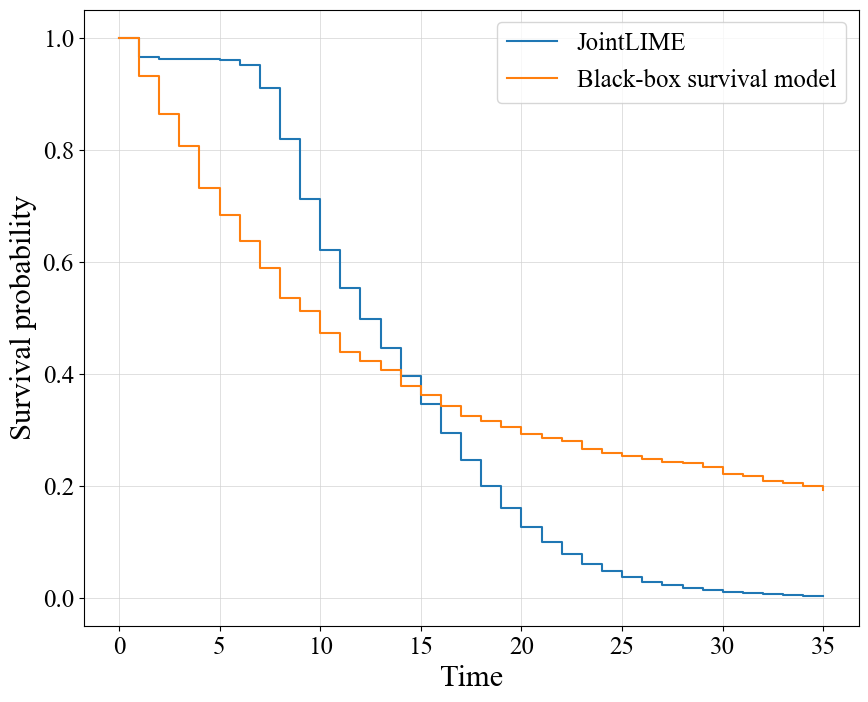

In [33]:
# max distance - survival function - jointlime
n_size = 100

x_values = np.arange(0, max_length+1)
y1 = np.append(1, target_max_s_jm)
y2 = np.append(1, target_max_s_bb_jm)

plt.figure(figsize=(10, 8))
plt.step(x_values, y1, label='JointLIME', where='post')
plt.step(x_values, y2, label='Black-box survival model', where='post')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Survival probability", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 1.05)
plt.yticks([0,0.2, 0.4,0.6,0.8,1])
plt.legend(fontsize=18)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/s_jm_max.jpg")

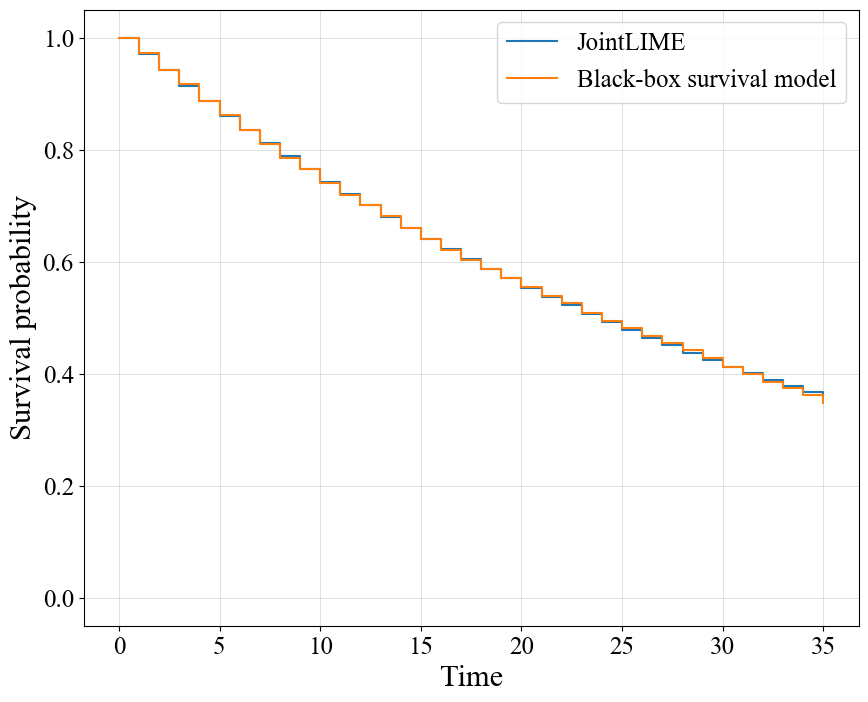

In [34]:
# min distance - survival function - jointlime
x_values = np.arange(0, max_length+1)
y1 = np.append(1, target_min_s_jm)
y2 = np.append(1, target_min_s_bb_jm)

plt.figure(figsize=(10, 8))
plt.step(x_values, y1, label='JointLIME', where='post')
plt.step(x_values, y2, label='Black-box survival model', where='post')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Survival probability", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 1.05)
plt.yticks([0,0.2, 0.4,0.6,0.8,1])
plt.legend(fontsize=18)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/s_jm_min.jpg")

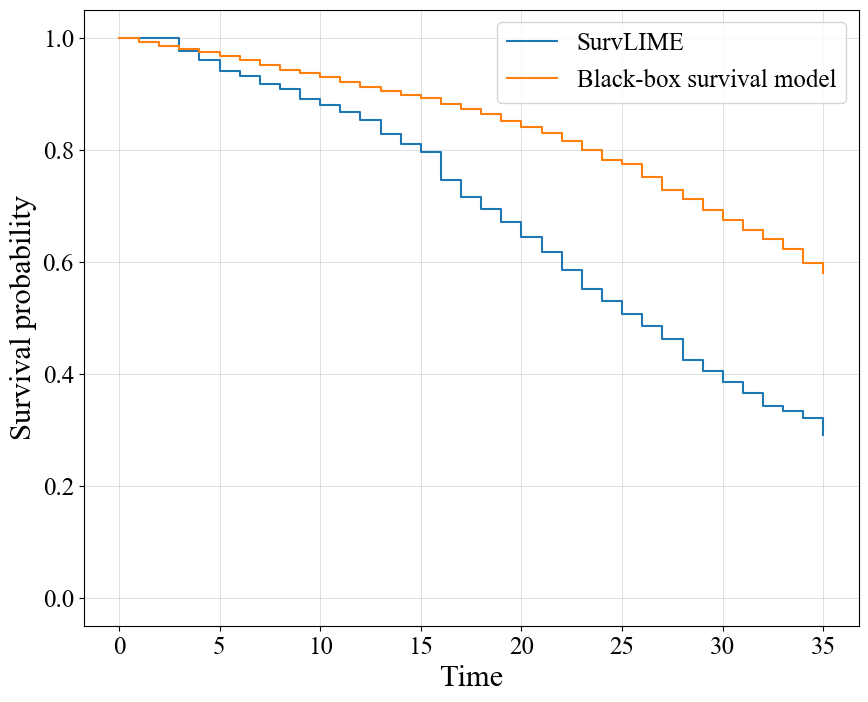

In [104]:
# max distance - survival function - survlime
x_values = np.arange(0, max_length+1)
y1 = np.append(1, target_max_s_survlime)
y2 = np.append(1, target_max_s_bb_survlime)

plt.figure(figsize=(10, 8))
plt.step(x_values, y1, label='SurvLIME', where='post')
plt.step(x_values, y2, label='Black-box survival model', where='post')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Survival probability", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 1.05)
plt.yticks([0,0.2, 0.4,0.6,0.8,1])
plt.legend(fontsize=18)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/s_survlime_max.jpg")

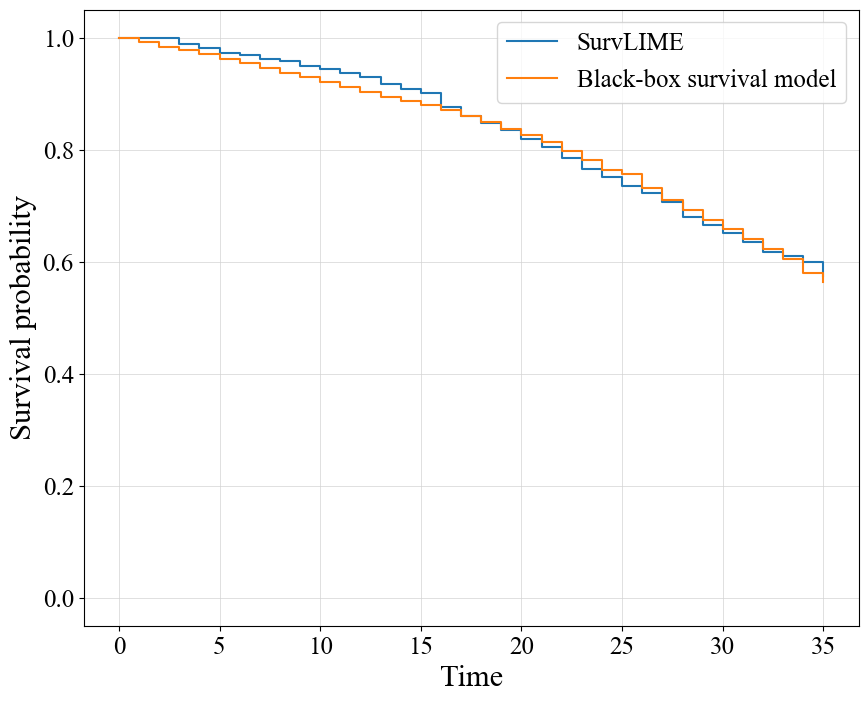

In [36]:
# min distance - survival function - survlime
x_values = np.arange(0, max_length+1)
y1 = np.append(1, target_min_s_survlime)
y2 = np.append(1, target_min_s_bb_survlime)

plt.figure(figsize=(10, 8))
plt.step(x_values, y1, label='SurvLIME', where='post')
plt.step(x_values, y2, label='Black-box survival model', where='post')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Survival probability", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 1.05)
plt.yticks([0,0.2, 0.4,0.6,0.8,1])
plt.legend(fontsize=18)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/s_survlime_min.jpg")

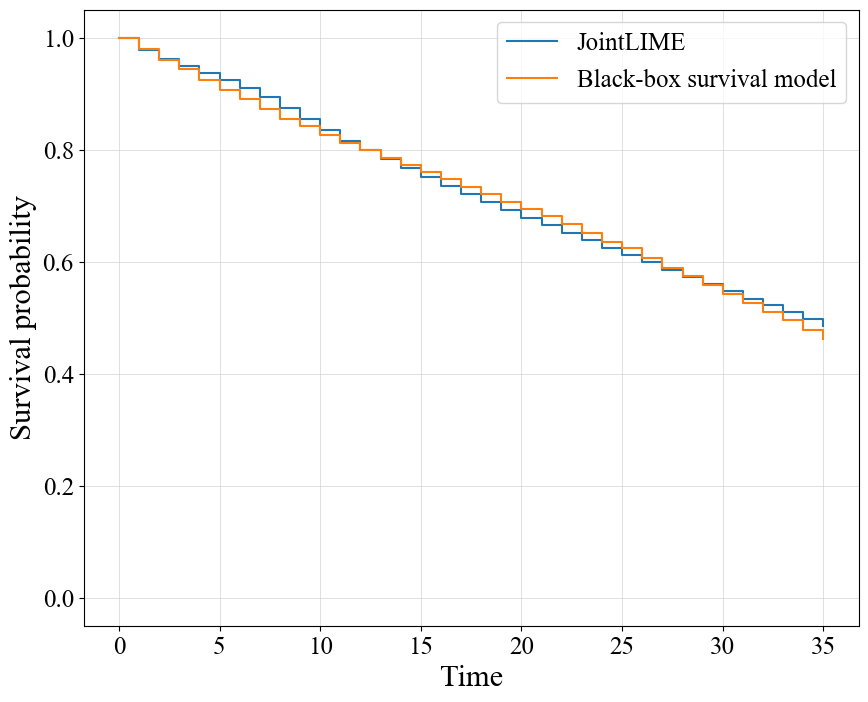

In [37]:
# mean distance - survival function - jointlime
x_values = np.arange(0, max_length+1)
y1 = np.append(1, target_mean_s_jm)
y2 = np.append(1, target_mean_s_bb)

plt.figure(figsize=(10, 8))
plt.step(x_values, y1, label='JointLIME', where='post')
plt.step(x_values, y2, label='Black-box survival model', where='post')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Survival probability", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 1.05)
plt.yticks([0,0.2, 0.4,0.6,0.8,1])
plt.legend(fontsize=18)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/s_jm_mean.jpg")

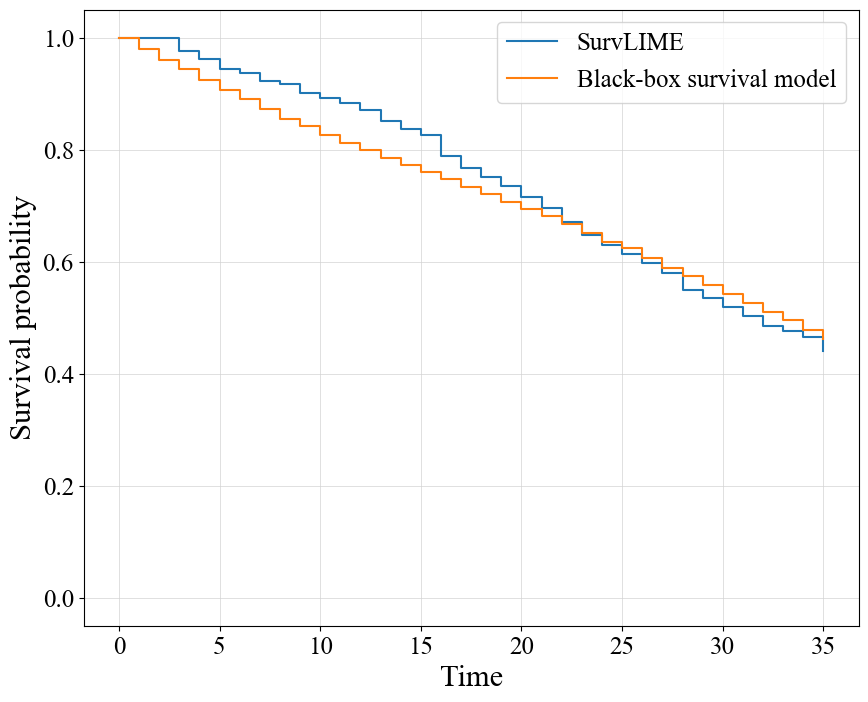

In [38]:
# mean distance - survival function - survlime
x_values = np.arange(0, max_length+1)
y1 = np.append(1, target_mean_s_survlime)
y2 = np.append(1, target_mean_s_bb)

plt.figure(figsize=(10, 8))
plt.step(x_values, y1, label='SurvLIME', where='post')
plt.step(x_values, y2, label='Black-box survival model', where='post')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Survival probability", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05, 1.05)
plt.yticks([0,0.2, 0.4,0.6,0.8,1])
plt.legend(fontsize=18)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/s_survlime_mean.jpg")

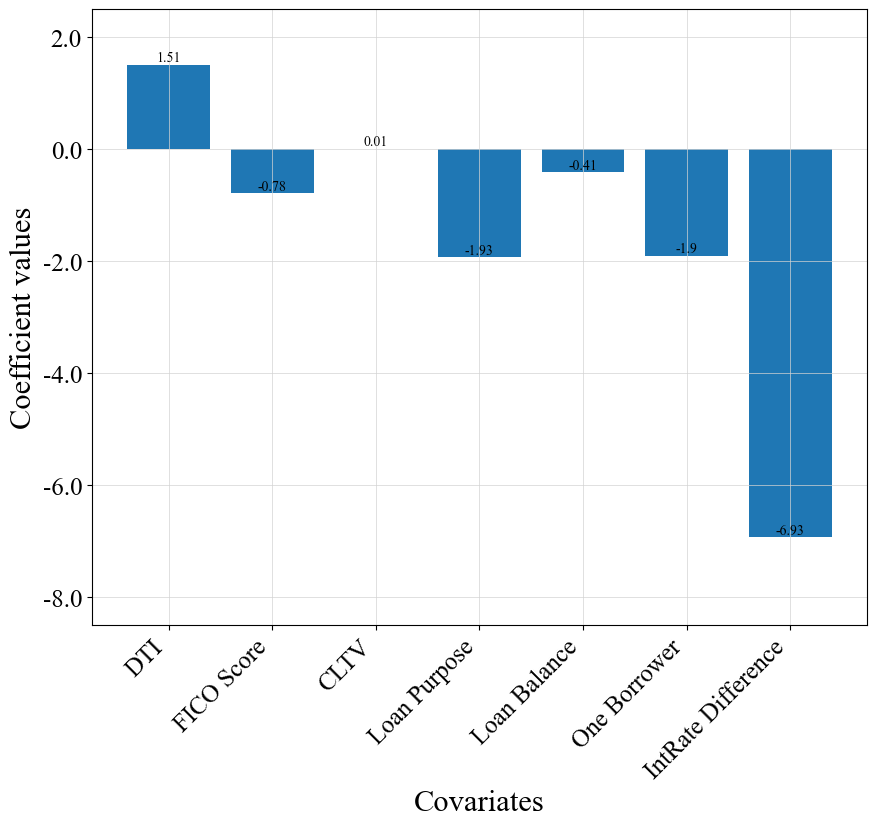

In [63]:
# max distance - parameters - jointlime
x = np.arange(len(target_max_param))
    
plt.figure(figsize=(10, 8))
plt.bar(x, target_max_param)

plt.xlabel("Covariates", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)
plt.xticks(x, ['DTI','FICO Score','CLTV','Loan Purpose','Loan Balance','One Borrower','IntRate Difference'], fontsize=18, rotation=45, ha='right')
plt.yticks(fontsize=18)

plt.ylim(-8.5, 2.5)
plt.yticks([-8,-6,-4,-2,0,2])

for i, v in enumerate(target_max_param):
    plt.text(x[i], round(v, 2), str(round(v, 2)), horizontalalignment="center", verticalalignment="bottom")
    
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/jm_coefficient_max.jpg", bbox_inches="tight")  

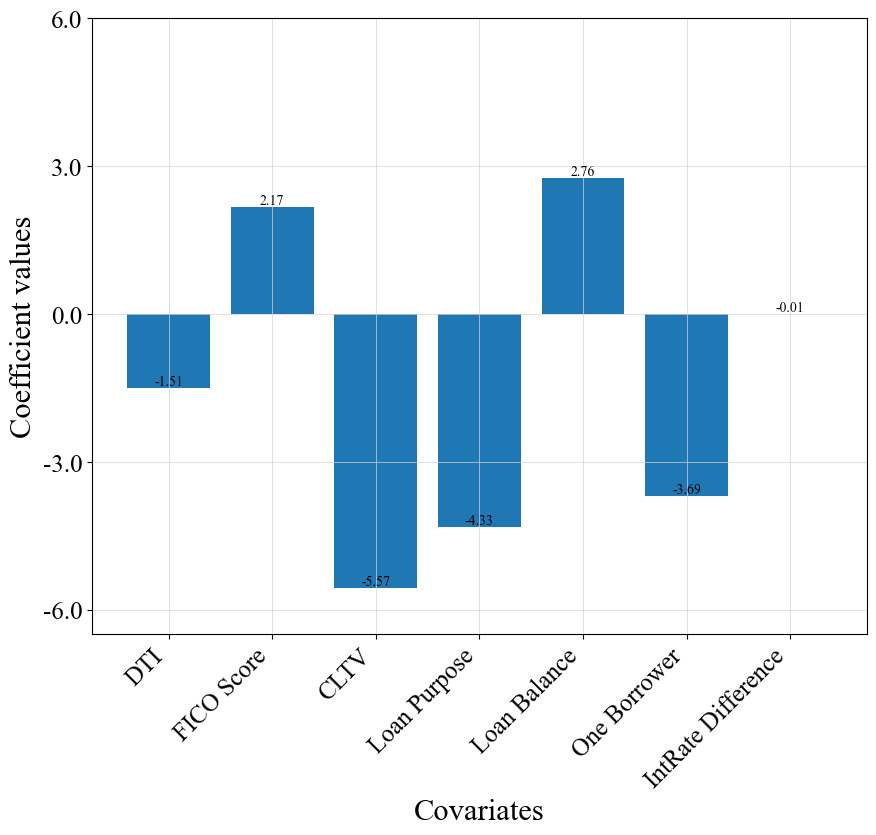

In [62]:
# min distance - parameters - jointlime
x = np.arange(len(target_min_param))
    
plt.figure(figsize=(10, 8))
plt.bar(x, target_min_param)

plt.xlabel("Covariates", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)
plt.xticks(x, ['DTI','FICO Score','CLTV','Loan Purpose','Loan Balance','One Borrower','IntRate Difference'], fontsize=18, rotation=45, ha='right')
plt.yticks(fontsize=18)

plt.ylim(-6.5, 3.5)
plt.yticks([-6,-3,0,3,6])

for i, v in enumerate(target_min_param):
    plt.text(x[i], round(v, 2), str(round(v, 2)), horizontalalignment="center", verticalalignment="bottom")
    
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/jm_coefficient_min.jpg", bbox_inches="tight") 

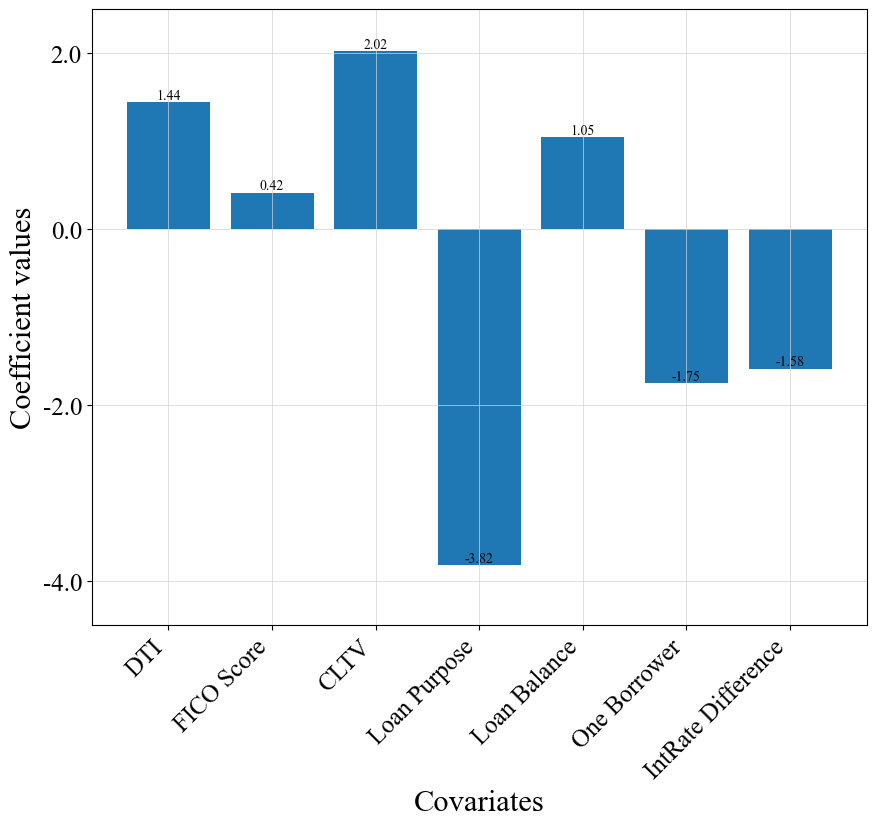

In [66]:
# mean distance - parameters - jointlime
x = np.arange(len(target_mean_param))
    
plt.figure(figsize=(10, 8))
plt.bar(x, target_mean_param)

plt.xlabel("Covariates", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)
plt.xticks(x, ['DTI','FICO Score','CLTV','Loan Purpose','Loan Balance','One Borrower','IntRate Difference'], fontsize=18, rotation=45, ha='right')
plt.yticks(fontsize=18)

plt.ylim(-4.5, 2.5)
plt.yticks([-4,-2,0,2])

for i, v in enumerate(target_mean_param):
    plt.text(x[i], round(v, 2), str(round(v, 2)), horizontalalignment="center", verticalalignment="bottom")

plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    
plt.savefig(out_path + "/plots/jm_coefficient_mean.jpg", bbox_inches="tight")  

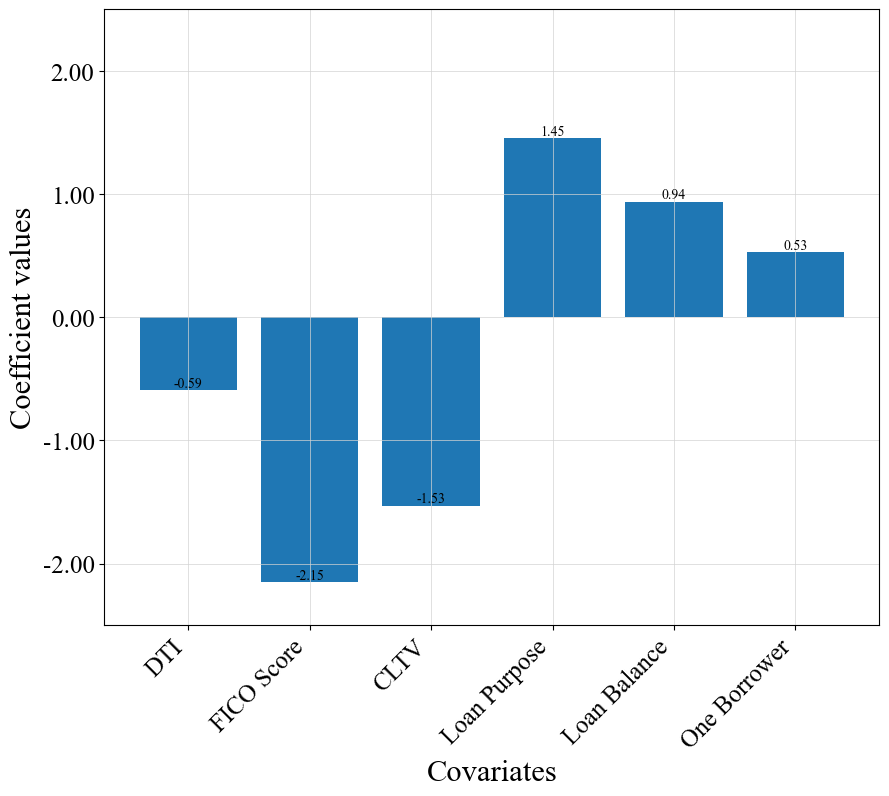

In [70]:
# max distance - parameters - survlime
x = np.arange(6)
    
plt.figure(figsize=(10, 8))
plt.bar(x, target_max_param_survlime[:6])

plt.xlabel("Covariates", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)
plt.xticks(x, ['DTI','FICO Score','CLTV','Loan Purpose','Loan Balance','One Borrower'], fontsize=18, rotation=45, ha='right')
plt.yticks(fontsize=18)

plt.ylim(-2.5, 2.5)
plt.yticks([-2,-1,0,1,2])

for i, v in enumerate(target_max_param_survlime[:6]):
    plt.text(x[i], round(v, 2), str(round(v, 2)), horizontalalignment="center", verticalalignment="bottom")

plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
plt.savefig(out_path + "/plots/survlime_coefficient_max.jpg", bbox_inches="tight")

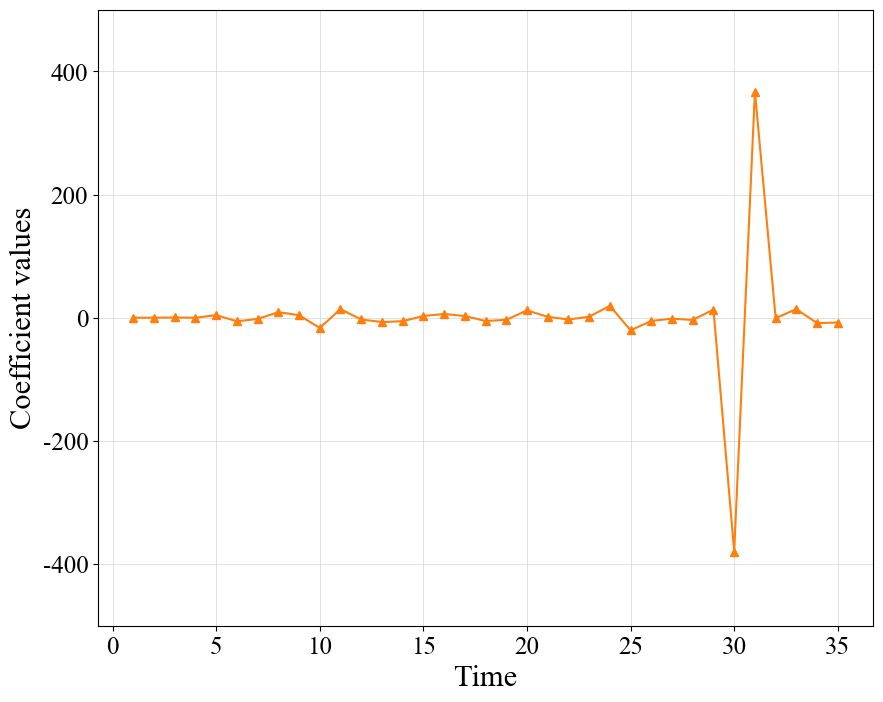

In [73]:
plt.figure(figsize=(10, 8))

x_values = np.arange(1, max_length+1)
y_values = target_max_param_survlime[-35:]    

plt.plot(x_values, y_values,marker='^',color='C1')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)

plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# plt.xticks(fontsize=14, rotation=45, ha='right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.ylim(-500, 500)
plt.yticks([-400,-200,0,200,400])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.savefig(out_path + "/plots/survlime_tvc_coef_max.jpg")

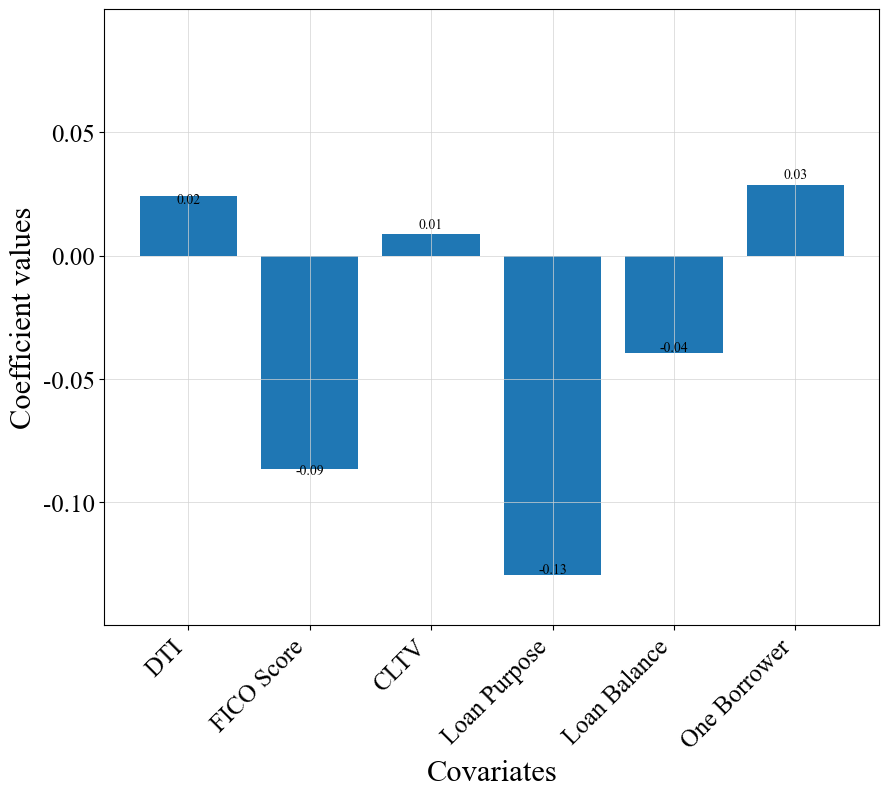

In [78]:
# min distance - parameters - survlime
x = np.arange(6)
    
plt.figure(figsize=(10, 8))
plt.bar(x, target_min_param_survlime[:6])

plt.xlabel("Covariates", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)
plt.xticks(x, ['DTI','FICO Score','CLTV','Loan Purpose','Loan Balance','One Borrower'], fontsize=18, rotation=45, ha='right')
plt.yticks(fontsize=18)

plt.ylim(-0.15, 0.1)
plt.yticks([-0.1,-0.05,0,0.05])

for i, v in enumerate(target_min_param_survlime[:6]):
    plt.text(x[i], round(v, 2), str(round(v, 2)), horizontalalignment="center", verticalalignment="bottom")

plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
plt.savefig(out_path + "/plots/survlime_coefficient_min.jpg", bbox_inches="tight")

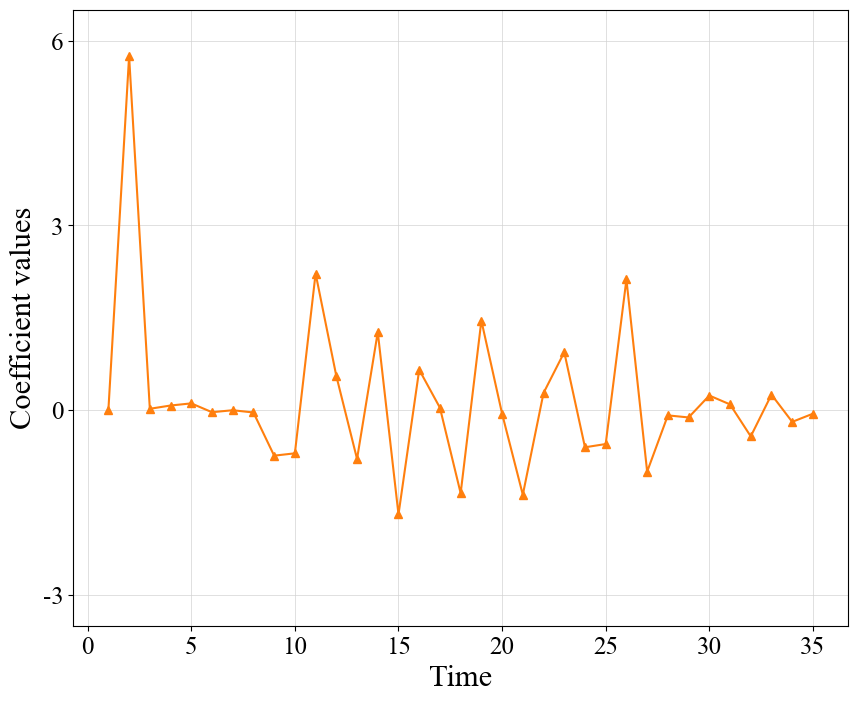

In [88]:
plt.figure(figsize=(10, 8))

x_values = np.arange(1, max_length+1)
y_values = target_min_param_survlime[-35:]    

plt.plot(x_values, y_values,marker='^',color='C1')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)

plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# plt.xticks(fontsize=14, rotation=45, ha='right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.ylim(-3.5, 6.5)
plt.yticks([-3,0,3,6])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    
plt.savefig(out_path + "/plots/survlime_tvc_coef_min.jpg")

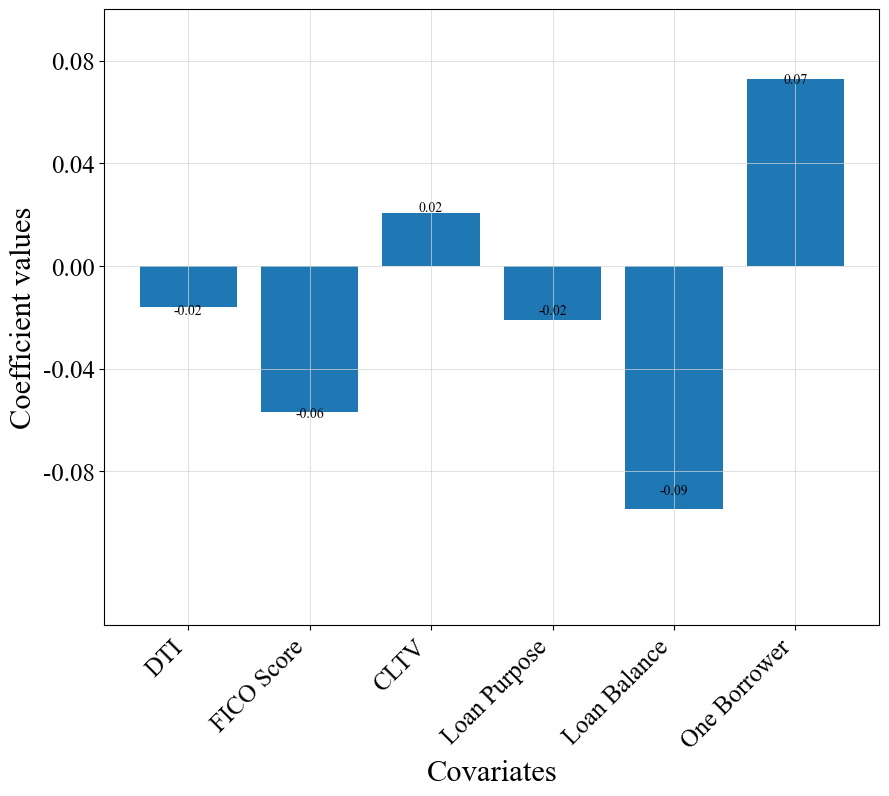

In [92]:
# mean distance - parameters - survlime
x = np.arange(6)
    
plt.figure(figsize=(10, 8))
plt.bar(x, target_mean_param_survlime[:6])

plt.xlabel("Covariates", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)
plt.xticks(x, ['DTI','FICO Score','CLTV','Loan Purpose','Loan Balance','One Borrower'], fontsize=18, rotation=45, ha='right')
plt.yticks(fontsize=18)

plt.ylim(-0.14, 0.1)
plt.yticks([-0.08,-0.04,0,0.04,0.08])

for i, v in enumerate(target_mean_param_survlime[:6]):
    plt.text(x[i], round(v, 2), str(round(v, 2)), horizontalalignment="center", verticalalignment="bottom")

plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
plt.savefig(out_path + "/plots/survlime_coefficient_mean.jpg", bbox_inches="tight")

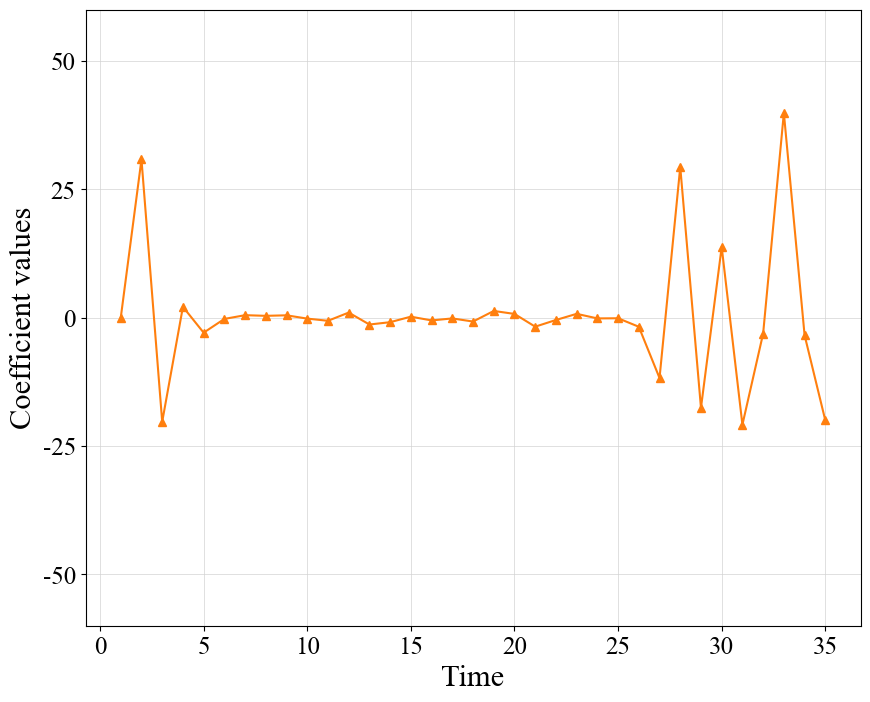

In [97]:
plt.figure(figsize=(10, 8))

x_values = np.arange(1, max_length+1)
y_values = target_mean_param_survlime[-35:]    

plt.plot(x_values, y_values,marker='^',color='C1')

plt.xlabel("Time", fontsize=22)
plt.ylabel("Coefficient values", fontsize=22)

plt.grid(color='lightgray', linestyle='-', linewidth=0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.ylim(-60, 60)
plt.yticks([-50,-25,0,25,50])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    
plt.savefig(out_path + "/plots/survlime_tvc_coef_mean.jpg")